In [1]:
# Importing all the required libraries

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

In [2]:
# Loading all the required datasets and combining them

files = [
    "api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric_500000_1000000.csv",
    "api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric_1500000_1861108.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print(df.shape)
print(df.head())

(1861108, 6)
         date              state      district  pincode  bio_age_5_17  \
0  01-03-2025            Haryana  Mahendragarh   123029           280   
1  01-03-2025              Bihar     Madhepura   852121           144   
2  01-03-2025  Jammu and Kashmir         Punch   185101           643   
3  01-03-2025              Bihar       Bhojpur   802158           256   
4  01-03-2025         Tamil Nadu       Madurai   625514           271   

   bio_age_17_  
0          577  
1          369  
2         1091  
3          980  
4          815  


In [ ]:
# Data Validation
# Ensure numeric columns are there
numeric_cols = ["bio_age_5_17", "bio_age_17_"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
df = df[(df[numeric_cols] >= 0).all(axis=1)]


In [ ]:
# Anomaly 1: No of people aged 5-17 are much higher than people aged 17 and above

z_scores = np.abs(zscore(df[numeric_cols]))
df["stat_anomaly"] = (z_scores > 5).any(axis=1)

df["logical_anomaly"] = (
    (df["bio_age_5_17"] > df["bio_age_17_"]) |
    (df["bio_age_5_17"] > 2000) |
    (df["bio_age_17_"] > 2000)
)

df["fraud_flag"] = df["stat_anomaly"] | df["logical_anomaly"]

state_summary = (
    df[df["fraud_flag"]]
    .groupby("state")[numeric_cols]
    .sum()
    .sort_values(by="bio_age_17_", ascending=False)
)

print(state_summary.head(10))

                bio_age_5_17  bio_age_17_
state                                    
Maharashtra          2215477      2789075
Uttar Pradesh        5760424      2753232
Madhya Pradesh       2694048      1919156
Bihar                1362991      1335779
Chhattisgarh          642601      1156928
Rajasthan            1447308       957589
Tamil Nadu           1438307       942903
Gujarat               958715       881959
Andhra Pradesh       1908404       740455
Jharkhand             596577       655749


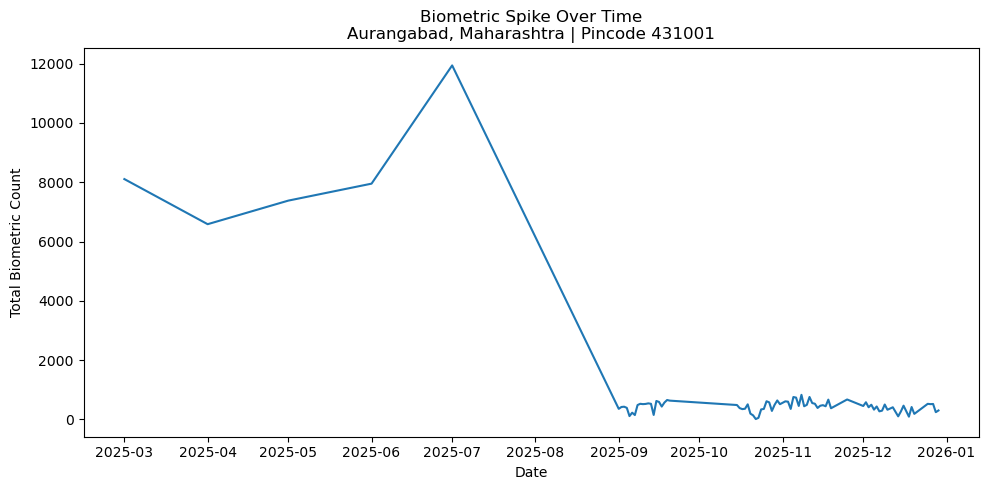

In [ ]:
# Anomaly 2: Sudden spike in biometric count of some Pin codes
# Converting date to standard format of DD-MM-YYYY
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
df["total_bio"] = df["bio_age_5_17"] + df["bio_age_17_"]
df = df[df["total_bio"] > 0]

df["pincode_group"] = df["pincode"].astype(str).str[:3]

group_cols = ["state", "district", "pincode_group", "date"]

group_stats = (
    df.groupby(group_cols)["total_bio"]
    .agg(["mean", "std"])
    .reset_index()
)

df = df.merge(group_stats, on=group_cols, how="left")

df["group_zscore"] = (df["total_bio"] - df["mean"]) / df["std"]
df["spike_flag"] = df["group_zscore"] > 4

top_spikes = (
    df[df["spike_flag"]]
    .groupby(["state", "district", "pincode"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

example = top_spikes.index[0]

sample = df[
    (df["state"] == example[0]) &
    (df["district"] == example[1]) &
    (df["pincode"] == example[2])
].sort_values("date")

plt.figure(figsize=(10, 5))
plt.plot(sample["date"], sample["total_bio"])
plt.title(f"Biometric Spike Over Time\n{example[1]}, {example[0]} | Pincode {example[2]}")
plt.xlabel("Date")
plt.ylabel("Total Biometric Count")
plt.tight_layout()
plt.show()

In [ ]:
# per day biometric details for suspicious pincodes
def view_daily_details_for_pincodes(df, pincodes, sort_by=["pincode", "date"]):
    """
    Returns per-day biometric details for a set of pincodes
    """

    table = (
        df[df["pincode"].isin(pincodes)]
        .sort_values(sort_by)[
            [
                "state",
                "district",
                "pincode",
                "date",
                "bio_age_5_17",
                "bio_age_17_",
                "total_bio",
                "mean",
                "std",
                "group_zscore",
                "spike_flag"
            ]
        ]
        .reset_index(drop=True)
    )

    return table

suspect_pincodes = [431001, 394210, 143001, 202001]

daily_table = view_daily_details_for_pincodes(
    df, suspect_pincodes
)

daily_table.head(15)


,state,district,pincode,date,bio_age_5_17,bio_age_17_,total_bio,mean,std,group_zscore,spike_flag
0,Punjab,Amritsar,143001,2025-03-01,2046,3687,5733,687.800000,974.763163,5.175821,True
1,Punjab,Amritsar,143001,2025-04-01,1930,3330,5260,622.685714,894.325733,5.185263,True
2,Punjab,Amritsar,143001,2025-05-01,1568,3644,5212,499.685714,861.135802,5.472208,True
3,Punjab,Amritsar,143001,2025-06-01,2296,3656,5952,554.257143,987.641735,5.465284,True
4,Punjab,Amritsar,143001,2025-07-01,2715,4266,6981,665.194444,1154.585314,5.470194,True
5,Punjab,Amritsar,143001,2025-09-01,92,146,238,19.342857,39.425240,5.546121,True
6,Punjab,Amritsar,143001,2025-09-02,79,119,198,17.285714,33.190689,5.444728,True
7,Punjab,Amritsar,143001,2025-09-03,77,82,159,11.256410,24.919574,5.928817,True
8,Punjab,Amritsar,143001,2025-09-04,74,143,217,17.815789,33.995115,5.859201,True
9,Punjab,Amritsar,143001,2025-09-05,91,108,199,18.729730,31.744333,5.678817,True


In [ ]:
# Anomaly 4: Varying biometric count for same regions at the same date
daily_table[daily_table['pincode'] == 431001]

,state,district,pincode,date,bio_age_5_17,bio_age_17_,total_bio,mean,std,group_zscore,spike_flag
296,Maharashtra,Chatrapati Sambhaji Nagar,431001,2025-03-01,41,246,287,287.000000,NaN,NaN,False
297,Maharashtra,Chhatrapati Sambhajinagar,431001,2025-03-01,15,106,121,93.500000,38.890873,0.707107,False
298,Maharashtra,Aurangabad,431001,2025-03-01,2490,5616,8106,866.257143,1319.476575,5.486829,True
299,Maharashtra,Aurangabad,431001,2025-04-01,2116,4468,6584,704.114286,1079.892881,5.444879,True
300,Maharashtra,Chatrapati Sambhaji Nagar,431001,2025-04-01,53,262,315,315.000000,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
545,Maharashtra,Chhatrapati Sambhajinagar,431001,2025-12-28,0,5,5,1.785714,1.311404,2.451026,False
546,Maharashtra,Chatrapati Sambhaji Nagar,431001,2025-12-29,1,4,5,3.000000,2.828427,0.707107,False
547,Maharashtra,Chhatrapati Sambhajinagar,431001,2025-12-29,2,3,5,1.800000,1.316561,2.430574,False
548,Maharashtra,Aurangabad,431001,2025-12-29,101,198,299,38.025641,63.372120,4.118126,True


In [ ]:
# Anomaly 5: Spike in biometric count after some gaps in between even after system repair
# like in Surat total days of spike = 83 but longest continuous spike = 22 only
spikes = (
    df[df["spike_flag"]].sort_values(["state", "district", "pincode", "date"])
)

spikes["prev_date"] = (
    spikes.groupby(["state", "district", "pincode"])["date"].shift(1)
)

spikes["gap_days"] = (
    spikes["date"] - spikes["prev_date"]
).dt.days

spikes["new_run"] = (
    (spikes["gap_days"].isna()) | (spikes["gap_days"] > 1)
)

spikes["run_id"] = (
    spikes.groupby(["state", "district", "pincode"])["new_run"].cumsum()
)

continuity_stats = (
    spikes.groupby(["state", "district", "pincode", "run_id"]).size()
    .reset_index(name="run_length")
)

final_continuity_stats = (
    continuity_stats
    .groupby(["state", "district", "pincode"])
    .agg(
        max_consecutive_spike_days=("run_length", "max"),
        spike_days=("run_length", "sum")
    )
    .reset_index()
)
final_continuity_stats.sort_values(
    ["max_consecutive_spike_days", "spike_days"],
    ascending=False
).head(10)


,state,district,pincode,max_consecutive_spike_days,spike_days
279,Gujarat,Surat,394210,22,83
581,Maharashtra,Aurangabad,431001,20,89
996,Uttar Pradesh,Aligarh,202001,17,75
957,Telangana,Karimnagar,505001,16,71
749,Rajasthan,Ajmer,305001,16,62
752,Rajasthan,Alwar,301001,16,51
1035,Uttarakhand,Dehradun,248001,15,54
589,Maharashtra,Kolhapur,416115,14,59
768,Rajasthan,Nagaur,341001,13,68
1019,Uttar Pradesh,Kanpur Nagar,208001,13,59
